In [16]:
import pandas as pd

# Load CSV (adjust name if needed)
df = pd.read_csv("data/FOMC_statements.csv")

# Drop rows where the date is missing
df = df[df["date"].notna()].copy()

# Convert float dates like 19961219.0 → '19961219' → datetime
df["date"] = pd.to_datetime(df["date"].astype(int).astype(str), format="%Y%m%d")

# Preview
df[["date"]].head()

,date
0,1996-12-19
1,1996-12-06
2,1996-12-05
3,1996-12-03
4,1996-11-25


In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load model + tokenizer
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Label order: ['negative', 'neutral', 'positive']
labels = ['negative', 'neutral', 'positive']

def get_sentiment_probs(text):
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    return dict(zip(labels, probs))

In [18]:
df = df.rename(columns={"date": "date", "text": "statement"})

# Convert date column to datetime
df["date"] = pd.to_datetime(df["date"])

df["probs"] = df["statement"].apply(get_sentiment_probs)

# Extract P(positive) - P(negative)
df["sentiment_score"] = df["probs"].apply(lambda d: d["positive"] - d["negative"])


In [ ]:
# Show results
df[["date", "sentiment_score"]]

,date,sentiment_score
0,1996-12-19,0.832228
1,1996-12-06,0.549390
2,1996-12-05,0.832341
3,1996-12-03,0.560425
4,1996-11-25,0.634494
...,...,...
1451,2020-02-05,0.840111
1452,2020-01-17,0.843432
1453,2020-01-16,-0.005241
1454,2020-01-09,-0.291306


In [20]:
import yfinance as yf

# Pull S&P 500 data (1995–today)
sp500 = yf.download("^GSPC", start="1995-01-01", end="2025-01-01")

# Pull 10-year Treasury yield (^TNX)
tnx = yf.download("^TNX", start="1995-01-01", end="2025-01-01")

# Keep only closing prices
sp500 = sp500[["Close"]].rename(columns={"Close": "sp500_close"})
tnx = tnx[["Close"]].rename(columns={"Close": "tnx_close"})

# Preview
sp500.tail(), tnx.tail()

C:\Users\jihed\AppData\Local\Temp\ipykernel_13768\263382344.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="1995-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\jihed\AppData\Local\Temp\ipykernel_13768\263382344.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tnx = yf.download("^TNX", start="1995-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


(Price       sp500_close
 Ticker            ^GSPC
 Date                   
 2024-12-24  6040.040039
 2024-12-26  6037.589844
 2024-12-27  5970.839844
 2024-12-30  5906.939941
 2024-12-31  5881.629883,
 Price      tnx_close
 Ticker          ^TNX
 Date                
 2024-12-24     4.591
 2024-12-26     4.579
 2024-12-27     4.619
 2024-12-30     4.545
 2024-12-31     4.573)

In [21]:
# Create a copy of full sentiment dataframe
sentiment_df = df.copy()

# Add 'next trading day' column
sentiment_df["next_day"] = sentiment_df["date"] + pd.Timedelta(days=1)

# Set index on market data
sp500.index = pd.to_datetime(sp500.index)
tnx.index = pd.to_datetime(tnx.index)

# Merge: get next-day values from market data
sentiment_df["sp500_next_close"] = sp500["sp500_close"].reindex(sentiment_df["next_day"]).values
sentiment_df["tnx_next_close"] = tnx["tnx_close"].reindex(sentiment_df["next_day"]).values
sentiment_df["sp500_prev_close"] = sp500["sp500_close"].reindex(sentiment_df["date"]).values
sentiment_df["tnx_prev_close"] = tnx["tnx_close"].reindex(sentiment_df["date"]).values

# Calculate % change
sentiment_df["sp500_change"] = (sentiment_df["sp500_next_close"] - sentiment_df["sp500_prev_close"]) / sentiment_df["sp500_prev_close"]
sentiment_df["tnx_change"] = (sentiment_df["tnx_next_close"] - sentiment_df["tnx_prev_close"]) / sentiment_df["tnx_prev_close"]

# Preview
sentiment_df[["date", "sentiment_score", "sp500_change", "tnx_change"]].head()

,date,sentiment_score,sp500_change,tnx_change
0,1996-12-19,0.832228,0.004170,-0.000631
1,1996-12-06,0.549390,NaN,NaN
2,1996-12-05,0.832341,-0.006421,0.005478
3,1996-12-03,0.560425,-0.004250,0.008934
4,1996-11-25,0.634494,-0.001413,0.000000


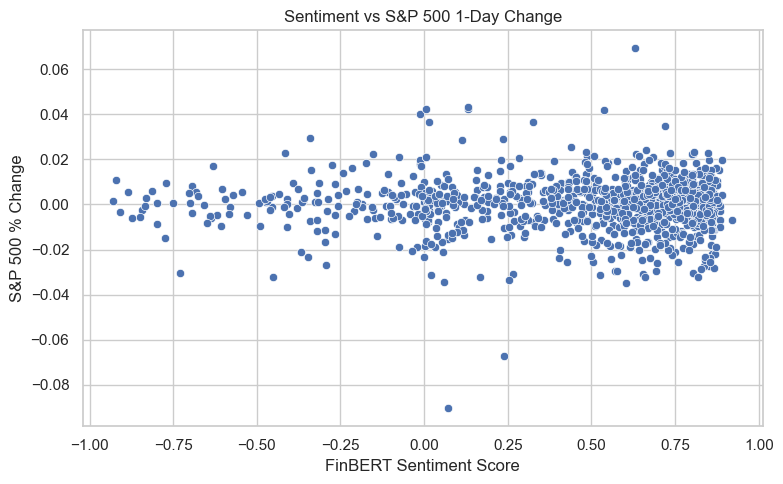

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")

# Scatter plot: Sentiment vs S&P 500 % change
plt.figure(figsize=(8, 5))
sns.scatterplot(data=sentiment_df, x="sentiment_score", y="sp500_change")
plt.title("Sentiment vs S&P 500 1-Day Change")
plt.xlabel("FinBERT Sentiment Score")
plt.ylabel("S&P 500 % Change")
plt.tight_layout()
plt.savefig("results/plot_sentiment_sp500.png")
plt.show()

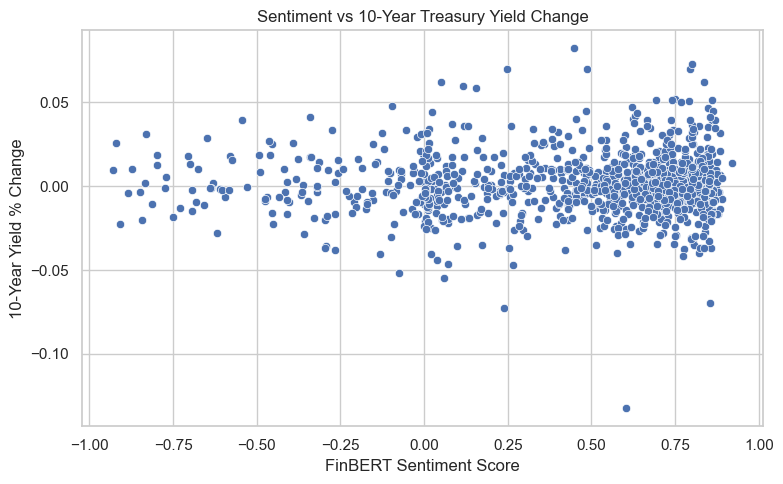

In [23]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=sentiment_df, x="sentiment_score", y="tnx_change")
plt.title("Sentiment vs 10-Year Treasury Yield Change")
plt.xlabel("FinBERT Sentiment Score")
plt.ylabel("10-Year Yield % Change")
plt.tight_layout()
plt.savefig("results/plot_sentiment_tnx.png")
plt.show()

In [26]:
import statsmodels.api as sm

# Drop missing values
reg_data = sentiment_df.dropna(subset=["sentiment_score", "sp500_change"])

# Define X and y
X = reg_data["sentiment_score"]
y = reg_data["sp500_change"]

# Add constant to X (intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           sp500_change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2111
Date:                Mon, 23 Jun 2025   Prob (F-statistic):              0.646
Time:                        08:43:45   Log-Likelihood:                 3237.4
No. Observations:                1062   AIC:                            -6471.
Df Residuals:                    1060   BIC:                            -6461.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3.743e-05      0.001     

In [27]:
with open("results/regression_summary_sp500.txt", "w") as f:
    f.write(model.summary().as_text())

In [28]:
import statsmodels.api as sm

# Drop missing values
reg_data = sentiment_df.dropna(subset=["sentiment_score", "tnx_change"])

# Define X and y
X = reg_data["sentiment_score"]
y = reg_data["tnx_change"]

# Add constant to X (intercept)
X = sm.add_constant(X)

# Fit the model
model2 = sm.OLS(y, X).fit()

# Print regression summary
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:             tnx_change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2570
Date:                Mon, 23 Jun 2025   Prob (F-statistic):              0.612
Time:                        08:43:59   Log-Likelihood:                 2749.0
No. Observations:                1060   AIC:                            -5494.
Df Residuals:                    1058   BIC:                            -5484.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0009      0.001     

In [29]:
with open("results/regression_summary_tnx.txt", "w") as f:
    f.write(model2.summary().as_text())